<a href="https://colab.research.google.com/github/bscot/TheLastMetric/blob/master/Example_TLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install required libraries

!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install astropy pzflow corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.4 MB/s eta 0:00:00


In [2]:
# import statements

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd 
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

In [4]:
# read in the data

!wget --quiet -O dataset.tar https://drive.google.com/u/0/uc?id=1t9_3GqjFGhpgdjiww6vlmijS-3rgVaC0&export=download
!tar -xf dataset.tar
!mv for_francois dataset

In [15]:
ls dataset/baseline_v1.4_10yrs/

test.cat  zphot.cat


In [30]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')


available_os = ['baseline_v1.4_10yrs', 'twilight_neo_mod1_v1.4_10yrs', 'var_expt_v1.4_10yrs', 'weather_1.2_v1.4_10yrs']
os_colors = {'baseline_v1.4_10yrs': 'k', 'twilight_neo_mod1_v1.4_10yrs': '#2ca02c', 'var_expt_v1.4_10yrs': '#1f77b4', 'weather_1.2_v1.4_10yrs': '#ff7f0e'}

phot_cats, z_cats = {}, {}
for one_os in available_os:
  test_cat = Table.read('dataset/'+one_os+'/test.cat', format='ascii')


  z_cat = Table.read('dataset/'+one_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read('dataset/'+one_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[one_os] = phot_cat
  z_cats[one_os] = z_cat
     

In [42]:
drop_cols = ['ID', 'z_true', 'u', 'g',  'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y']


In [43]:
phot_cats['baseline_v1.4_10yrs']

ID,z_true,u,g,r,i,z,y,err_u,err_g,err_r,err_i,err_z,err_y,u-g,g-r,r-i,i-z,z-y,err_u-g,err_g-r,err_r-i,err_i-z,err_z-y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5142370,1.61149,24.121025,0.053106,24.084064,0.021194,24.181071,0.020409,24.123542,0.028792,23.935485,0.044166,23.675364,0.074801,0.036961,0.057179,-0.097007,0.029423,0.057529,0.035292,0.188057,0.052722,0.260121,0.086867
10264978,0.6093701,25.452115,0.146893,25.112487,0.047829,24.362166,0.02385,23.863323,0.024224,23.721593,0.036951,23.736725,0.072242,0.339628,0.154484,0.750321,0.053446,0.498843,0.033995,0.14173,0.044184,-0.015132,0.081144
14377082,1.4589336,24.812845,0.099648,24.708982,0.036467,24.659695,0.031157,24.417965,0.036453,23.912078,0.041897,23.50922,0.056821,0.103862,0.106111,0.049287,0.047964,0.24173,0.047954,0.505887,0.055536,0.402858,0.070597
1763375,0.8317933,25.239161,0.167837,25.307067,0.062421,25.126998,0.04635,24.42418,0.036193,24.12068,0.051602,24.131831,0.101631,-0.067906,0.179069,0.180069,0.077747,0.702819,0.058807,0.3035,0.063029,-0.011151,0.113981
7447092,1.6073463,24.761218,0.101785,24.784247,0.037954,24.998465,0.040439,24.650014,0.051406,24.467265,0.07371,24.47997,0.119431,-0.023029,0.10863,-0.214218,0.05546,0.348451,0.065405,0.182749,0.089865,-0.012705,0.140346
8482528,1.7008493,24.417782,0.077821,24.231526,0.024681,24.613342,0.029089,24.139406,0.030481,23.781078,0.038448,23.650186,0.065284,0.186256,0.081641,-0.381816,0.038149,0.473935,0.042134,0.358329,0.049065,0.130892,0.075765
18058,0.9633236,24.885715,0.111038,25.021937,0.046457,25.077632,0.043183,24.767374,0.048662,24.433121,0.066705,24.269179,0.13901,-0.136222,0.120365,-0.055694,0.063427,0.310257,0.06506,0.334254,0.082569,0.163942,0.154186
14547315,1.0057881,24.058781,0.055269,24.235431,0.02475,24.127675,0.019664,23.758553,0.021739,23.331442,0.024653,23.318065,0.049809,-0.176649,0.060558,0.107756,0.031611,0.369122,0.029313,0.427111,0.032869,0.013377,0.055577
1350298,1.4956608,24.764686,0.099332,24.843673,0.04026,24.989548,0.04001,24.893349,0.060474,24.824052,0.094631,24.462323,0.143879,-0.078986,0.107181,-0.145875,0.05676,0.096199,0.072511,0.069297,0.112304,0.361729,0.17221


In [44]:
phot_cats['baseline_v1.4_10yrs'].to_pandas().drop(drop_cols, axis = 1)

,r,u-g,g-r,r-i,i-z,z-y
0,24.084064,0.036961,0.057179,-0.097007,0.029423,0.057529
1,25.112487,0.339628,0.154484,0.750321,0.053446,0.498843
2,24.708982,0.103862,0.106111,0.049287,0.047964,0.241730
3,25.307067,-0.067906,0.179069,0.180069,0.077747,0.702819
4,24.784247,-0.023029,0.108630,-0.214218,0.055460,0.348451
...,...,...,...,...,...,...
45462,22.080703,0.271577,0.016842,0.700831,0.007753,0.509448
45463,24.540088,-0.229271,0.072840,-0.001388,0.041451,0.080327
45464,25.006379,-0.179055,0.121841,0.023662,0.061587,0.255780
45465,24.348074,0.029458,0.080878,0.769493,0.028877,0.492897


In [45]:
# conditional_columns = phot_cats['baseline_v1.4_10yrs'].to_pandas().drop(drop_cols, axis = 1)

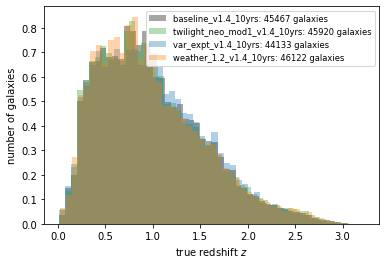

In [12]:
from matplotlib.pyplot import hist, xlabel, ylabel, legend 

for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=50, alpha=0.35, color=os_colors[which_os], 
       label=which_os+': '+str(len(phot_cats[which_os]))+' galaxies', density = True)
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')

In [16]:
# up to this point, using exact routines from TLM - switching to CASTOR inherited scripts

In [55]:
# mins = [0, 20, -5, -5, -5, -5, -5]
# maxs = [6, 30, 5, 5, 5, 5, 5]

# the data column is the one that is sampled and transformed by the flow
data_columns = ["z_true"]

all_cond_cols = {}
ensembles = dict()

for os in available_os:#catalogs.keys():
 # the conditional columns are the columns that the flow is conditioned on
  #conditional_columns = phot_cats[os].columns.drop('z_true')#["r", "g-r", "r-i", "i-z"] #, "uv-u", "u-g"] # different colors than LSST
  conditional_columns = phot_cats['baseline_v1.4_10yrs'].to_pandas().drop(drop_cols, axis = 1)
  all_cond_cols[os] = conditional_columns
  # print((os, conditional_columns))
  ndcol = len(data_columns)
  ncond = len(conditional_columns)
  ndim = ndcol+ncond

# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
# bijector = Chain(
#     StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
#     NeuralSplineCoupling(n_conditions=6)
# )
#   bijector = Chain(
#     # InvSoftplus(z_col, sharpness),
#     ShiftBounds(0, 6, B=4),
#     RollingSplineCoupling(nlayers=1, n_conditions=ncond, B=6),
#   )

  bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=6)
  )

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
# latent = Uniform(1, 5) # did the syntax here change?

  latent = Uniform(input_dim=ndcol, B=7)#(-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5))

  flowEns2 = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                          #  info = info#, 
                          #  N = 10
                            )
  ensembles[os] = flowEns2

In [54]:
ensembles

{'baseline_v1.4_10yrs': <pzflow.flowEnsemble.FlowEnsemble at 0x7fe9693f0cd0>,
 'twilight_neo_mod1_v1.4_10yrs': <pzflow.flowEnsemble.FlowEnsemble at 0x7fe9693f0940>,
 'var_expt_v1.4_10yrs': <pzflow.flowEnsemble.FlowEnsemble at 0x7fe9693f0b80>,
 'weather_1.2_v1.4_10yrs': <pzflow.flowEnsemble.FlowEnsemble at 0x7fe9840a16d0>}

In [64]:
# temporary

from google.colab import drive
drive.mount('/content/drive')
prepend = '/content/drive/MyDrive/Research/RubinPz/'

Mounted at /content/drive


In [65]:
ls '/content/drive/MyDrive/Research/RubinPz/'

In [66]:
# tav_train, tav_test = {}, {}
for os in available_os:#:
    ens  = ensembles[os]
    # get the data and make a train and test set
    cat = phot_cats[os].to_pandas()
    # cat_train = cat.sample(frac = 0.99)
    # cat_test = cat.drop(cat_train.index)
    cat_train = cat
    print(os)
    # train the flow on the given learning rate schedule
    loss = ens.train(cat_train,#conditional_columns], 
                               convolve_errs=False,
                       epochs = 100, verbose=True)
    # loss2 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 312)
    # loss3 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 231)
    
    # losses = {fname : # for each flow trained in the ensemble...
    #               [float(loss) # save the list of training losses
    #                for lossDict in [loss1]#, loss2, loss3]
    #                for loss in lossDict[fname]]
    #           for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    # test_loss = -np.mean(ens.log_prob(cat_test))
    print(os, train_loss)#, test_loss)
    # post_trained[os] = ens
    # save the ensemble
    ens.save(prepend+f"pzflow_ensemble_for_{os}.pkl")
    # and the losses
    with open(prepend+f"losses_for_{os}.pkl", "wb") as file:
        pickle.dump({"losses": loss, 
                     "train loss": train_loss, 
                    #  "test loss": test_loss,
                     "train_ids": cat_train.index},
                    file)
        
    # mutual_information_lower_bound_train = ens.log_prob(cat_train, returnEnsemble=True)
    # mutual_information_lower_bound_test = ens.log_prob(cat_test, returnEnsemble=True)
    # tav_train[os] = mutual_information_lower_bound_train
    # tav_test[os] = mutual_information_lower_bound_test


baseline_v1.4_10yrs
Flow 0
Training 100 epochs 
Loss:
(0) -1.7144
(1) -1.7097
(6) -1.6567
(11) -1.7108
(16) -1.7077
(21) -1.6828
(26) -1.7061
(31) -1.6636
(36) -1.7109
(41) -1.7195
(46) -1.6372
(51) -1.7106
(56) -1.7143
(61) -1.7246
(66) -1.7173
(71) -1.7377
(76) -1.7384
(81) -1.7255
(86) -1.7302
(91) -1.7335
(96) -0.6500
(100) -1.6745
baseline_v1.4_10yrs -1.6744854
twilight_neo_mod1_v1.4_10yrs
Flow 0
Training 100 epochs 
Loss:
(0) 1.5806
(1) 0.2340
(6) -0.9356
(11) -1.0980
(16) -1.1727
(21) -1.2376
(26) -1.2737
(31) -1.3070
(36) -1.3346
(41) -1.3084
(46) -1.3705
(51) -1.4138
(56) -1.4216
(61) -1.4141
(66) -1.4297
(71) -1.4171
(76) -1.4373
(81) -1.4380
(86) -1.4467
(91) -1.4690
(96) -1.4898
(100) -1.4957
twilight_neo_mod1_v1.4_10yrs -1.4956824
var_expt_v1.4_10yrs
Flow 0
Training 100 epochs 
Loss:
(0) 1.5626
(1) 0.0775
(6) -0.9369
(11) -1.1786
(16) -1.2725
(21) -1.2132
(26) -1.3745
(31) -1.3472
(36) -1.3399
(41) -1.4319
(46) -1.3030
(51) -1.3467
(56) -1.4948
(61) -1.5104
(66) -1.5060
(7